In [1]:
import tensorflow as tf
import tensorflow.keras as k
import matplotlib.pyplot as plt
import numpy as np
from datasets import load_spiral_dataset
tf.random.set_seed(42)


### PLot functions

In [2]:
def plot_scatter(X:np.ndarray, Y:np.ndarray):
    '''
    Show the scatter plot of flower dataset
    
    Parameters
    ----------
    X : numpy.ndarray [shape: (#features, #samples)]
        matrix of data; dtype: float64
    Y : numpy.ndarray [shape: (1, #samples)]
        array containing true labels 0 or 1; dtype: uint8 
    '''
    scatter=plt.scatter(X[0, :], X[1, :], c=Y, s=40, cmap=plt.cm.Spectral)
    plt.legend(*scatter.legend_elements(), loc="upper right", title="Classes")
    plt.xlabel('feature 1')
    plt.ylabel('feature 2')
    # plt.show()
    

def plot_decision_boundary(predict, X, Y):
    """
    Plot the decision boundary for logistic regression
    
    Parameters
    ----------
    predict : function
        predicted output; dtype=int8 
    parameters : dict
    X : numpy.ndarray [shape: (#features, #samples)]
        matrix of data; dtype: float64
    Y : numpy.ndarray [shape: (1, #samples)]
        array containing true labels 0 or 1; dtype: uint8
    """
    # Set min and max values and give it some padding
    x_min, x_max = X[0, :].min() - 1, X[0, :].max() + 1
    y_min, y_max = X[1, :].min() - 1, X[1, :].max() + 1
    h = 0.01
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict the function value for the whole grid
    # Y = None argument is dumpy as not used when print_accuracy=False
    a=tf.constant(np.c_[xx.ravel(), yy.ravel()],dtype=tf.float32)
    Z = predict(a,  batch_size=xx.size, verbose=0)
    Z = tf.argmax(Z, axis=-1)
    Z = Z.numpy().reshape(xx.shape)
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    plot_scatter(X,Y)
    # plt.xlim(-1.1, 1.1)
    # plt.ylim(-1.1, 1.1)

### Import data

(1000, 2) (1000, 1)


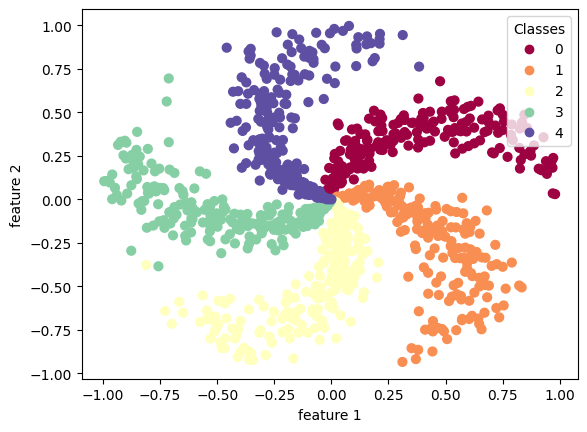

In [3]:
X_np,Y_np = load_spiral_dataset(N=1000, noise=0.2, K=5) # x->(D,N), y->(1,N)
X=tf.constant(X_np.T, dtype=tf.float32) # x->(N,D)=(1000,2)
Y=tf.constant(Y_np.reshape(-1,1), dtype=tf.uint8) # y->(N,1)=(1000,1)
print(X.shape, Y.shape)
plot_scatter(X_np,Y_np)

In [4]:
unique_labels = tf.unique(tf.squeeze(Y)).y
unique_labels

<tf.Tensor: shape=(5,), dtype=uint8, numpy=array([0, 1, 2, 3, 4], dtype=uint8)>

In [5]:
Y_true = tf.one_hot( Y[:,-1], depth=5 )

In [6]:
Y_true[::100]

<tf.Tensor: shape=(10, 5), dtype=float32, numpy=
array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.]], dtype=float32)>

### L Layer Neural Network Model

In [7]:
def L_layer_model(train_X, train_Y, layers_dims, learning_rate=0.0075, num_epochs=2000, activation_L_1="relu", activation_L="sigmoid", print_cost=False):
    """
    L layer neural network with different activation function on output layer option.
    
    Parameters
    ----------
    train_X : Tensor [shape: (#samples, #features)]; dtype=tf.float32
    train_Y : Tensor [shape: (#samples, 1)]; dtype=tf.float32
    layers_dims : list of int; list of number of nodes in each layer

    Returns
    -------
    forward : trained model
    costs : list of cost every 100 iteration
    """
    costs = []                                        # To keep track of the cost
    L = len(layers_dims) # number of layers in the network
    k.utils.set_random_seed(42)

    ## Initialize model
    forward = k.models.Sequential()
    # layers initialized; [1:L-1] X activation_L_1 + [L] X activation_L
    for l in range(1, L-1):
        forward.add( k.layers.Dense(units=layers_dims[l], activation=activation_L_1, input_shape=(layers_dims[l-1],),
                                    kernel_initializer=k.initializers.HeUniform(), bias_initializer="zeros") )
    forward.add( k.layers.Dense(units=layers_dims[-1], activation=activation_L, input_shape=(layers_dims[-2],),
                                kernel_initializer=k.initializers.GlorotUniform(), bias_initializer="zeros") )
    # forward.summary()

    ## Compile the model
    forward.compile(
        optimizer=k.optimizers.Adam(learning_rate=learning_rate),
        loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False, reduction='sum'),
        metrics=[k.metrics.CategoricalAccuracy()],
    )

    class print_on_end(k.callbacks.Callback):
        def __init__(self, show_epoch=100):
            self.show_epoch = show_epoch
        def on_epoch_end(self, epoch, logs=None):
            if epoch % self.show_epoch == 0 or epoch==self.params['epochs']-1:
                print(f"{epoch+1}/{self.params['epochs']}    loss: {logs['loss']},  categorical_accuracy: {logs['categorical_accuracy']*100}%")
    if print_cost:
        callbacks=[print_on_end(100)]
    else:
        callbacks=[]

    ## Train the model
    hist = forward.fit(train_X, train_Y, epochs=num_epochs, shuffle=False, batch_size=train_X.shape[0],
                     verbose=0,callbacks=callbacks)
    
    return hist


def plot_costs(costs, learning_rate):
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per hundreds)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()

### Detailed info, plots demo

1/2000    loss: 1620.693359375,  categorical_accuracy: 20.100000500679016%
101/2000    loss: 1260.2135009765625,  categorical_accuracy: 73.19999933242798%
201/2000    loss: 810.34228515625,  categorical_accuracy: 86.2999975681305%
301/2000    loss: 488.1737060546875,  categorical_accuracy: 91.00000262260437%
401/2000    loss: 321.288818359375,  categorical_accuracy: 93.50000023841858%
501/2000    loss: 237.05728149414062,  categorical_accuracy: 95.49999833106995%
601/2000    loss: 187.1815643310547,  categorical_accuracy: 95.99999785423279%
701/2000    loss: 153.19625854492188,  categorical_accuracy: 96.79999947547913%
801/2000    loss: 128.65264892578125,  categorical_accuracy: 97.50000238418579%
901/2000    loss: 110.34941864013672,  categorical_accuracy: 98.29999804496765%
1001/2000    loss: 95.56126403808594,  categorical_accuracy: 98.60000014305115%
1101/2000    loss: 83.23014068603516,  categorical_accuracy: 98.69999885559082%
1201/2000    loss: 73.10855102539062,  categorical_ac

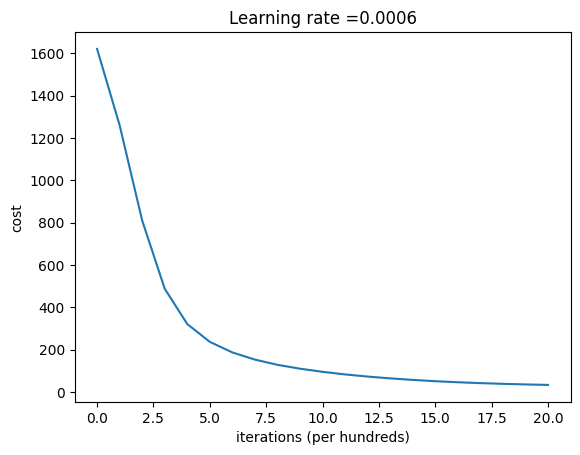

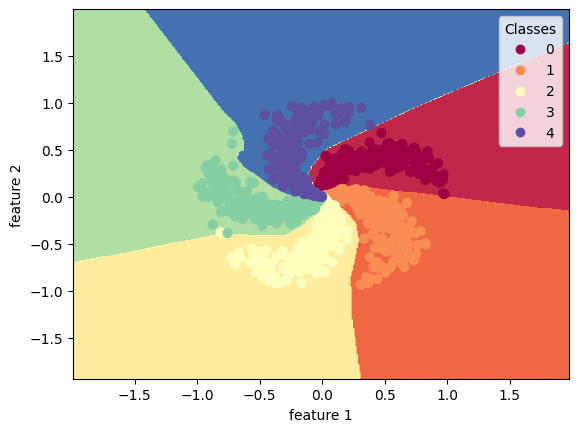

In [8]:
num_epochs=2000; activation_L_1="relu"; activation_L="softmax"
learning_rate = 0.0006; layers_dims=[X.shape[-1],12,12,12, 5]

nn_model = L_layer_model(X, Y_true, layers_dims, learning_rate, num_epochs, activation_L_1, activation_L, print_cost=True)
Y_pred = nn_model.model.predict(X, batch_size=X.shape[0], verbose=0)
acc = k.metrics.CategoricalAccuracy()
acc.reset_states()
acc.update_state(Y_true, Y_pred)
print(f"train accuracy: { acc.result().numpy().item() *100 } %")
costs = nn_model.history["loss"][0::100]
costs.append(nn_model.history['loss'][-1])
plot_costs(costs, learning_rate)
plot_decision_boundary(nn_model.model.predict, X_np, Y_np)

### Single Layer(Output layer) Model Run

1/2000    loss: 1579.475830078125,  categorical_accuracy: 29.6999990940094%
101/2000    loss: 1547.471435546875,  categorical_accuracy: 34.59999859333038%
201/2000    loss: 1517.0875244140625,  categorical_accuracy: 38.199999928474426%
301/2000    loss: 1488.055419921875,  categorical_accuracy: 41.49999916553497%
401/2000    loss: 1460.245361328125,  categorical_accuracy: 44.80000138282776%
501/2000    loss: 1433.548828125,  categorical_accuracy: 48.19999933242798%
601/2000    loss: 1407.878173828125,  categorical_accuracy: 50.80000162124634%
701/2000    loss: 1383.1610107421875,  categorical_accuracy: 52.10000276565552%
801/2000    loss: 1359.3367919921875,  categorical_accuracy: 52.99999713897705%
901/2000    loss: 1336.3544921875,  categorical_accuracy: 57.499998807907104%
1001/2000    loss: 1314.1702880859375,  categorical_accuracy: 62.300002574920654%
1101/2000    loss: 1292.74609375,  categorical_accuracy: 64.60000276565552%
1201/2000    loss: 1272.0472412109375,  categorical_acc

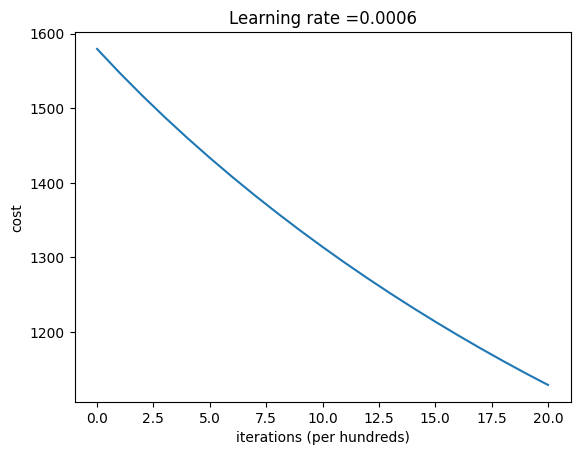

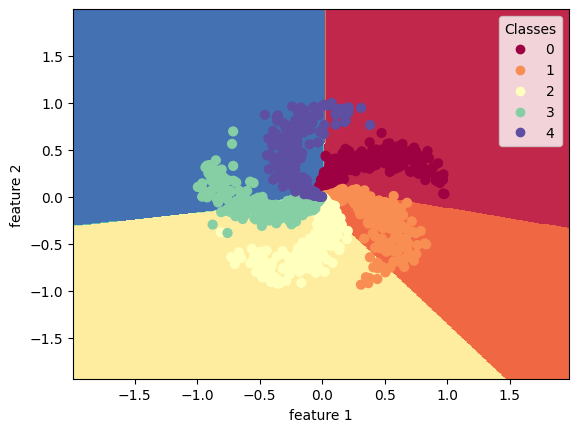

In [9]:
num_epochs=2000; activation_L_1="relu"; activation_L="softmax"
learning_rate = 0.0006; layers_dims=[X.shape[-1], 5]

nn_model = L_layer_model(X, Y_true, layers_dims, learning_rate, num_epochs, activation_L_1, activation_L, print_cost=True)
Y_pred = nn_model.model.predict(X, batch_size=X.shape[0], verbose=0)
acc = k.metrics.CategoricalAccuracy()
acc.reset_states()
acc.update_state(Y_true, Y_pred)
print(f"train accuracy: { acc.result().numpy().item() *100 } %")
costs = nn_model.history["loss"][0::100]
costs.append(nn_model.history['loss'][-1])
plot_costs(costs, learning_rate)
plot_decision_boundary(nn_model.model.predict, X_np, Y_np)

### 2 Layers (or 1 hidden layer) Neural Network

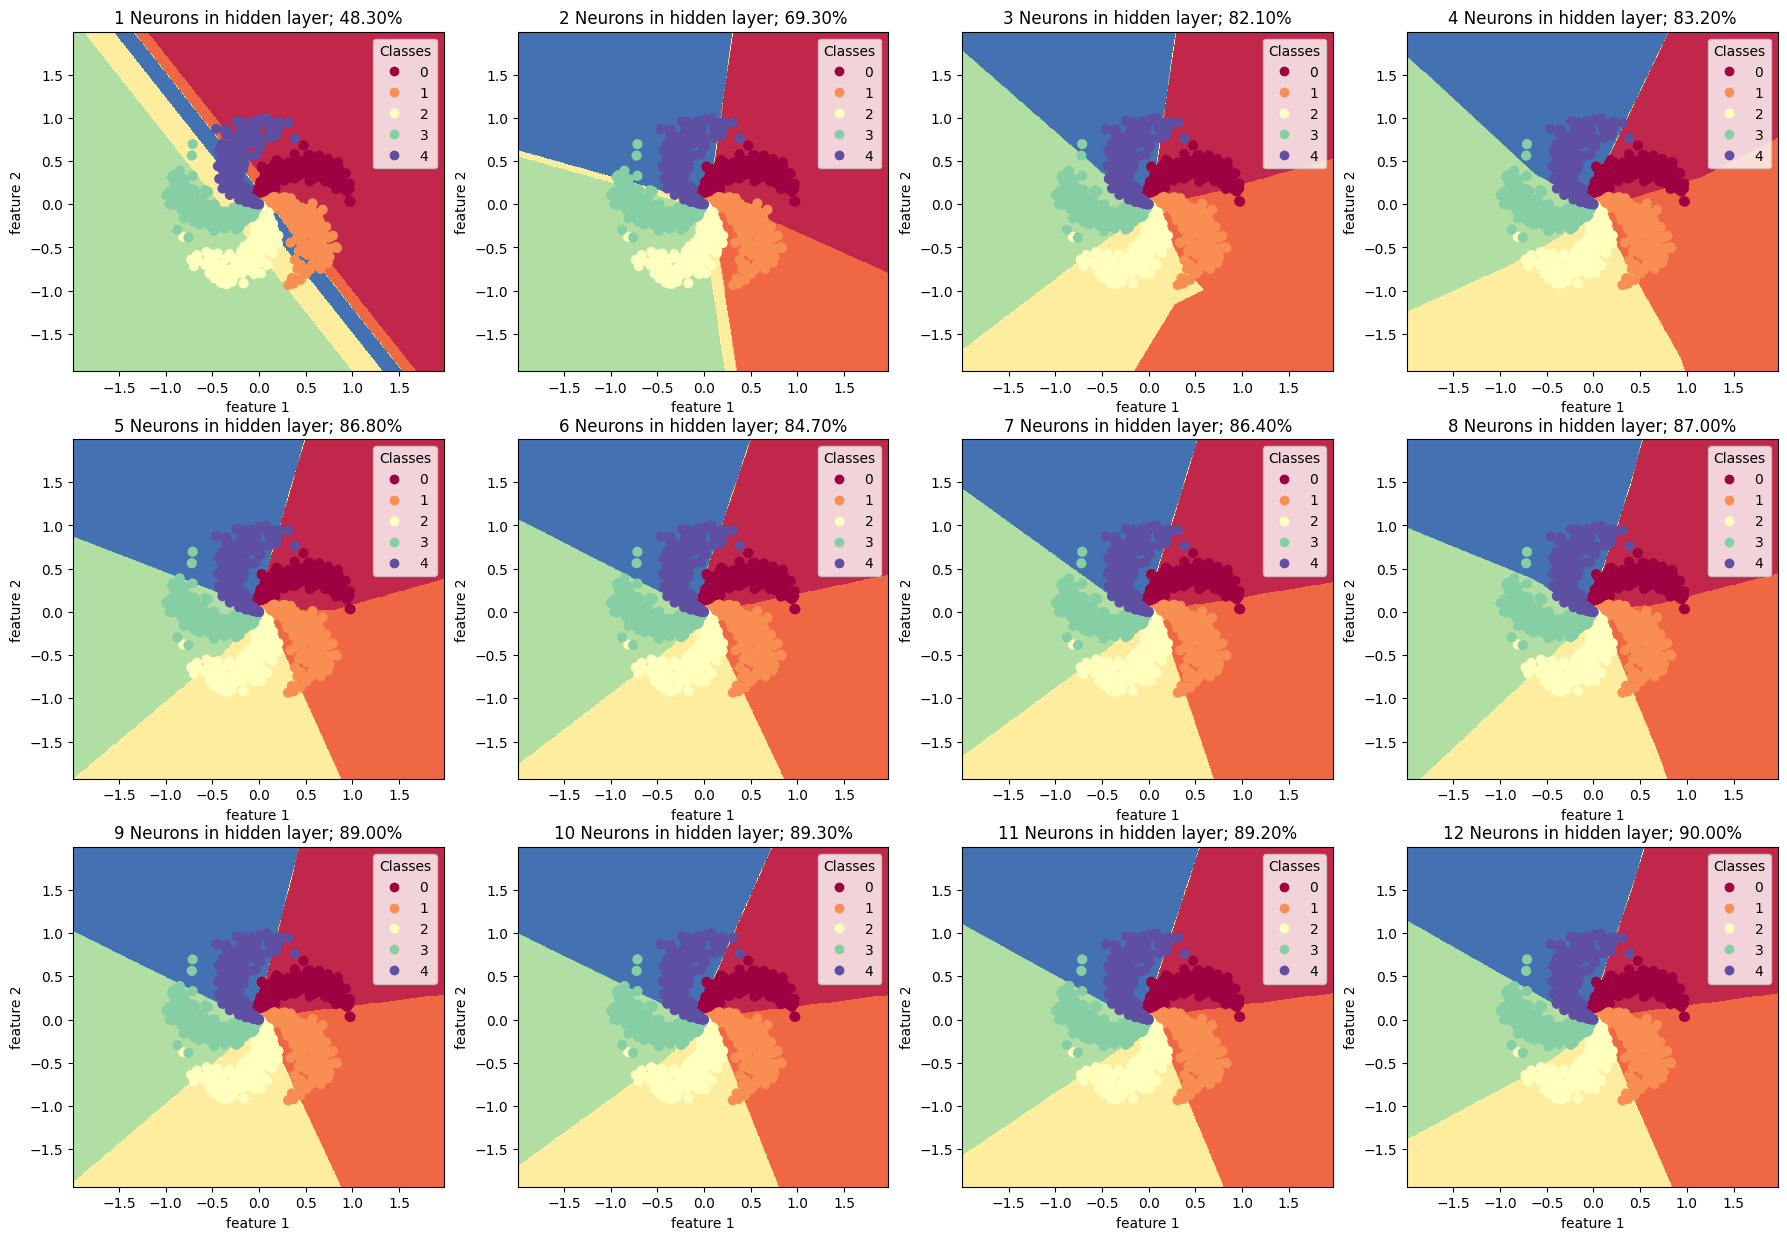

In [10]:
num_epochs=2000; activation_L_1="relu"; activation_L="softmax"
learning_rate = 0.0006; layers_dims=[X.shape[-1],1, 5]
plt.rcParams['figure.figsize'] = (22.0, 15.0) # width, height
for i in range(1,13):
    layers_dims=[X.shape[-1],i, 5]
    plt.subplot(3, 4, i)
    nn_model = L_layer_model(X, Y_true, layers_dims, learning_rate, num_epochs, activation_L_1, activation_L, print_cost=False)
    Y_pred = nn_model.model.predict(X, batch_size=X.shape[0], verbose=0)
    acc.reset_states()
    acc.update_state(Y_true, Y_pred)
    plot_decision_boundary(nn_model.model.predict, X_np, Y_np)
    plt.title(f"{i} Neurons in hidden layer; {acc.result().numpy().item()*100:.2f}%")
plt.show()
plt.rcParams["figure.figsize"] = plt.rcParamsDefault["figure.figsize"]

### 3 Layers (or 2 hidden layer) Neural Network

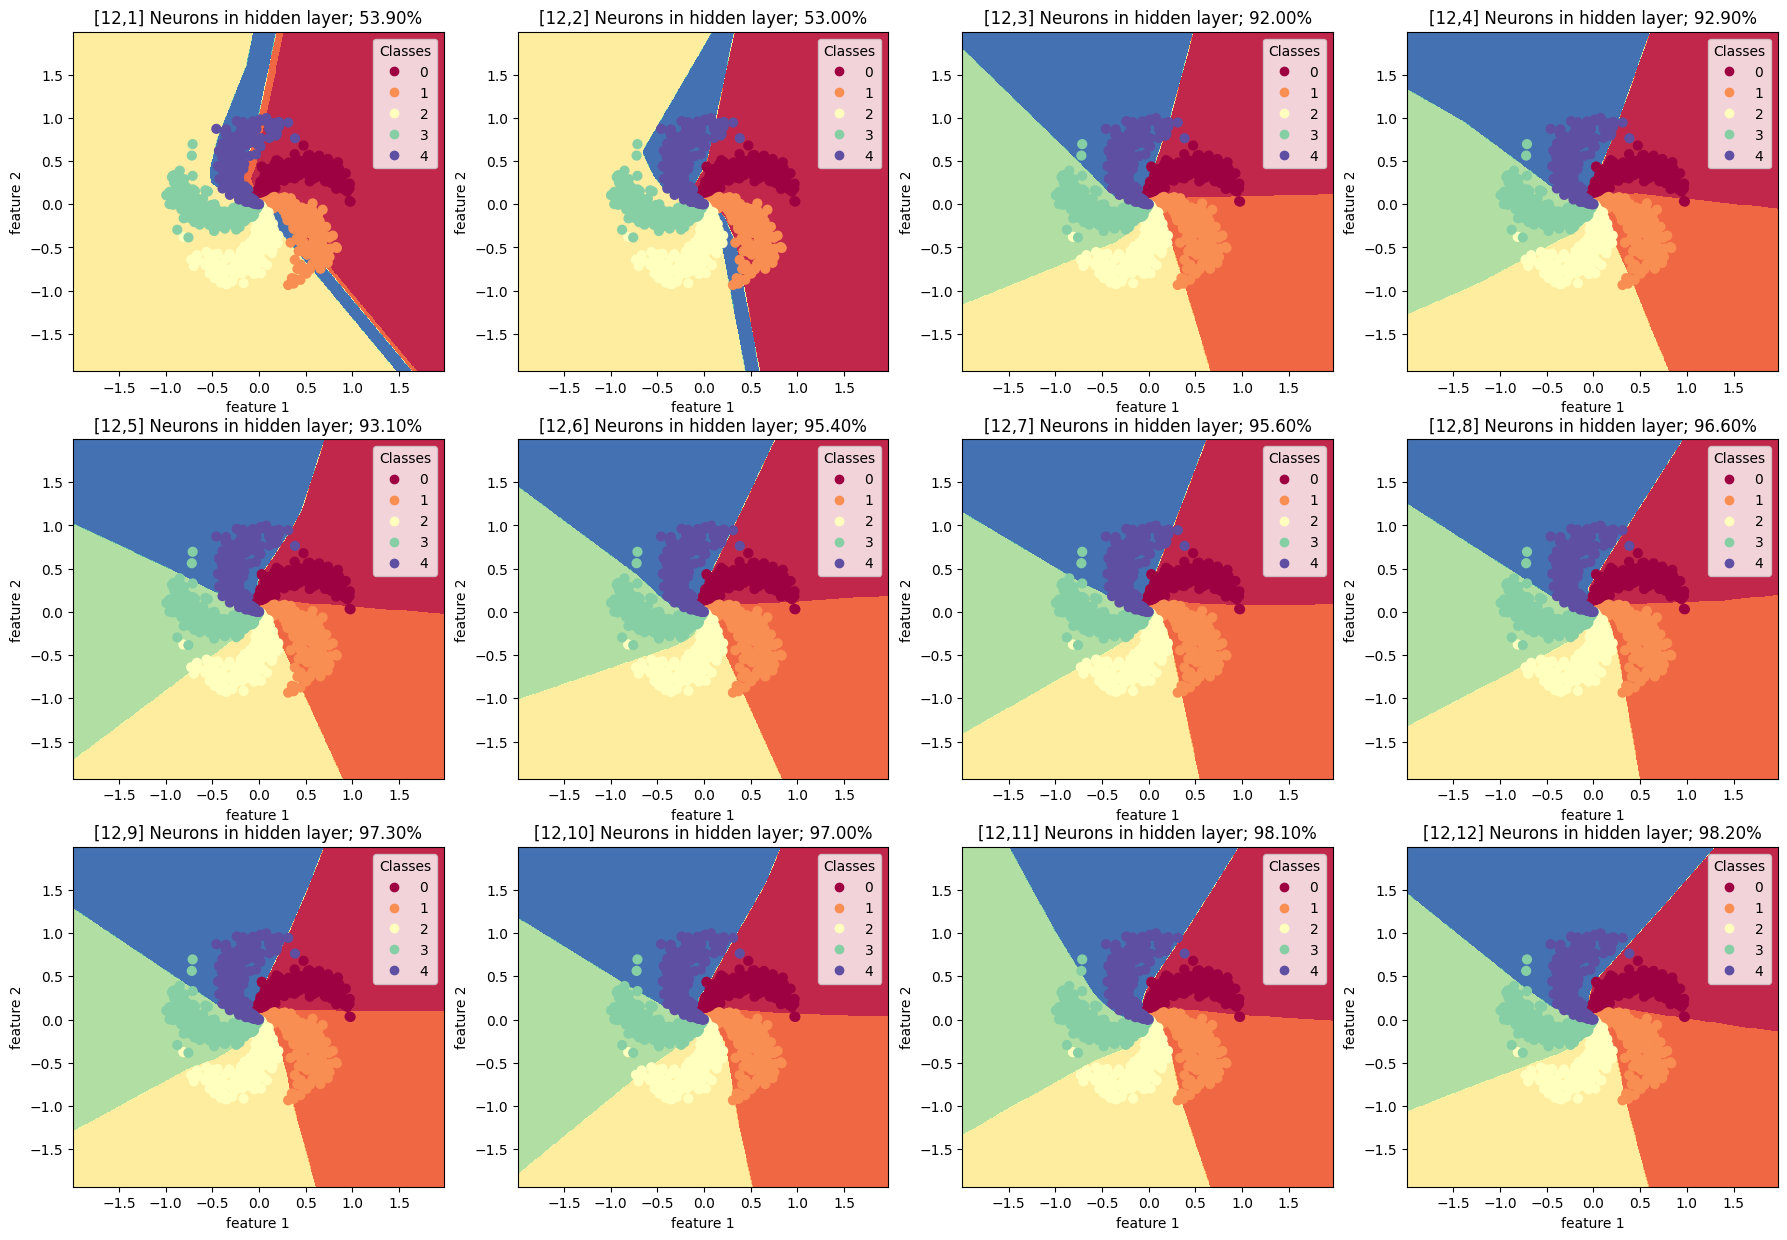

In [11]:
num_epochs=2000; activation_L_1="relu"; activation_L="softmax"
learning_rate = 0.0006; layers_dims=[X.shape[-1],12,1, 5]
plt.rcParams['figure.figsize'] = (22.0, 15.0) # width, height
for i in range(1,13):
    layers_dims=[X.shape[-1],12, i, 5]
    plt.subplot(3, 4, i)
    nn_model = L_layer_model(X, Y_true, layers_dims, learning_rate, num_epochs, activation_L_1, activation_L, print_cost=False)
    Y_pred = nn_model.model.predict(X, batch_size=X.shape[0], verbose=0)
    acc.reset_states()
    acc.update_state(Y_true, Y_pred)
    plot_decision_boundary(nn_model.model.predict, X_np, Y_np)
    plt.title(f"[12,{i}] Neurons in hidden layer; {acc.result().numpy().item()*100:.2f}%")
plt.show()
plt.rcParams["figure.figsize"] = plt.rcParamsDefault["figure.figsize"]

### 4 Layers (or 3 hidden layer) Neural Network

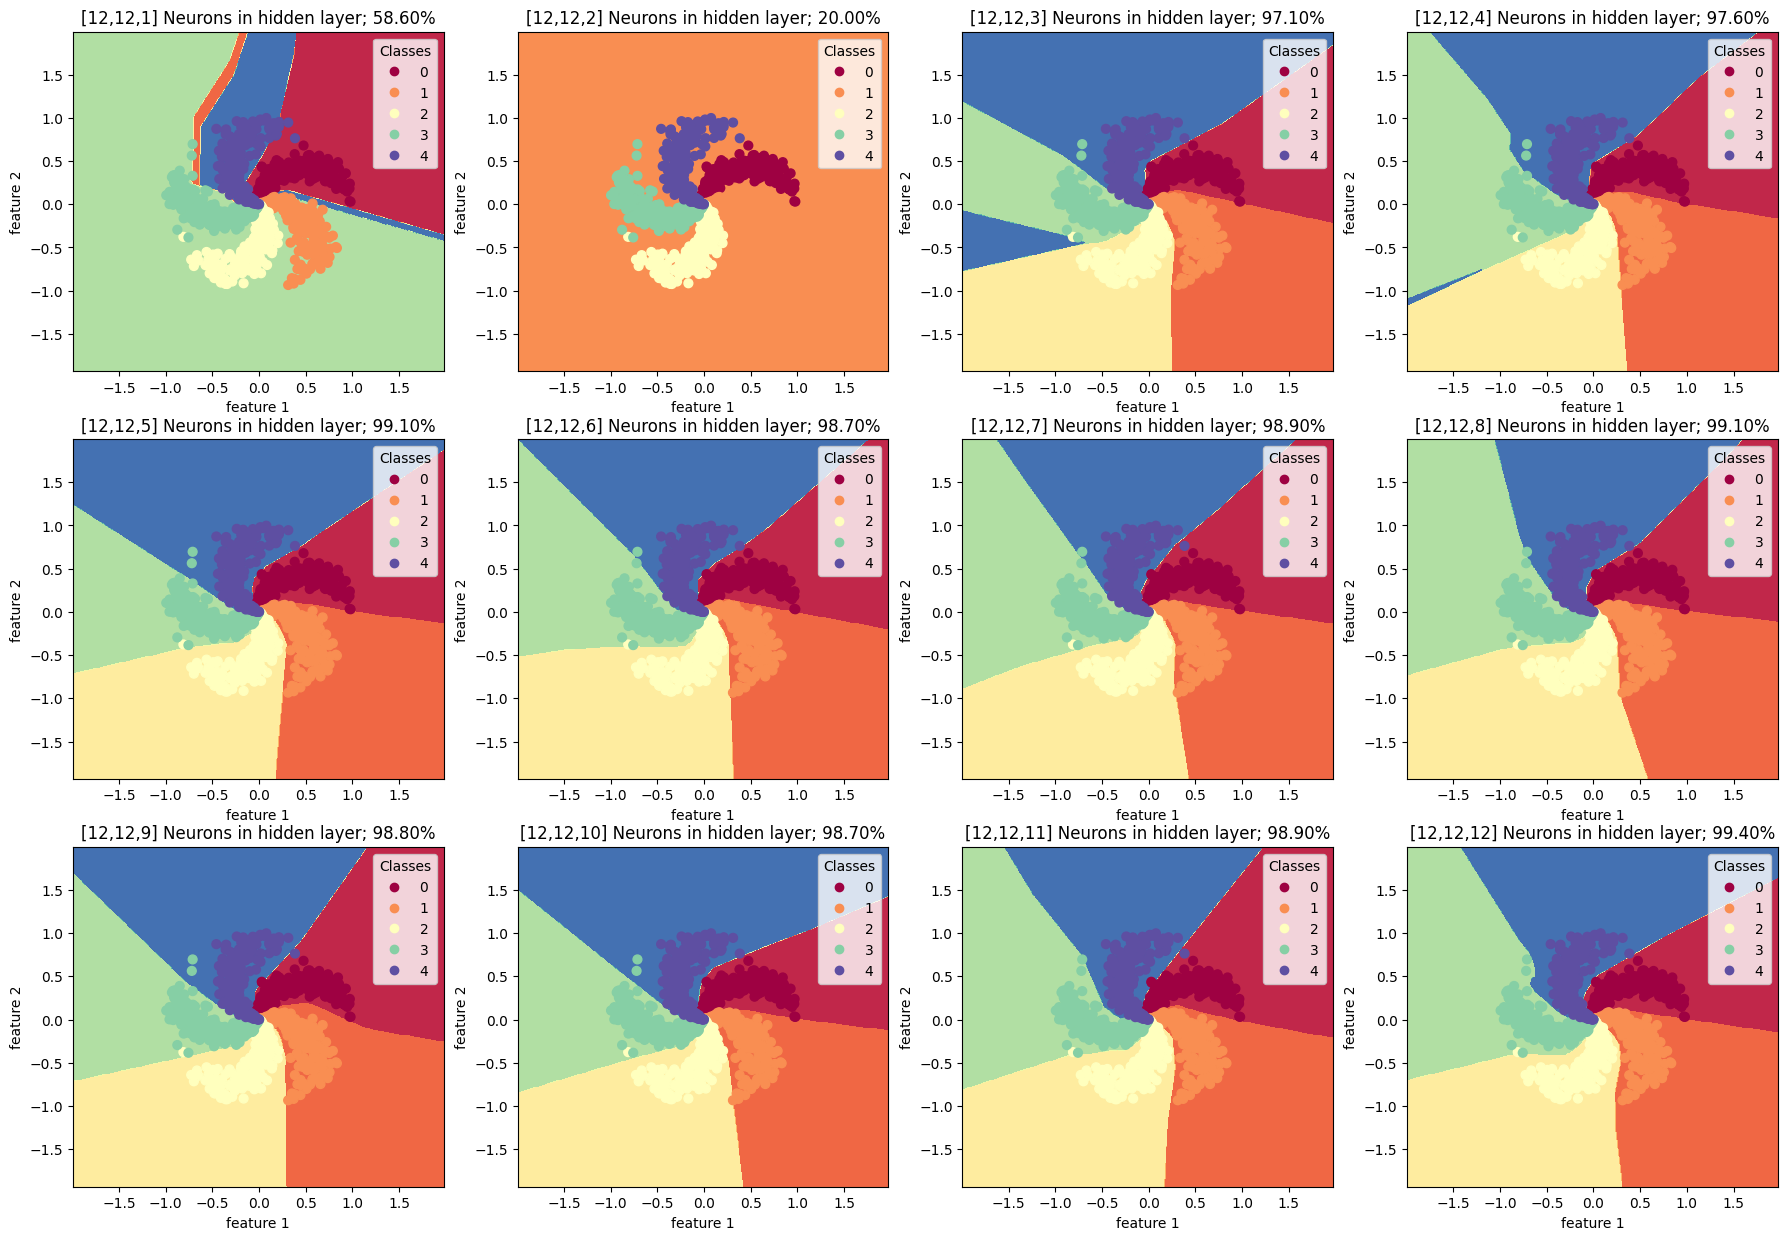

In [12]:
num_epochs=2000; activation_L_1="relu"; activation_L="softmax"
learning_rate = 0.0006; layers_dims=[X.shape[-1],12,12,1, 5]
plt.rcParams['figure.figsize'] = (22.0, 15.0) # width, height
for i in range(1,13):
    layers_dims=[X.shape[-1],12,12, i, 5]
    plt.subplot(3, 4, i)
    nn_model = L_layer_model(X, Y_true, layers_dims, learning_rate, num_epochs, activation_L_1, activation_L, print_cost=False)
    Y_pred = nn_model.model.predict(X, batch_size=X.shape[0], verbose=0)
    acc.reset_states()
    acc.update_state(Y_true, Y_pred)
    plot_decision_boundary(nn_model.model.predict, X_np, Y_np)
    plt.title(f"[12,12,{i}] Neurons in hidden layer; {acc.result().numpy().item()*100:.2f}%")

### Conclusion

4 layer neural networks in general give best results and adding more layers is increasing accuracy by much but probably overfitting.

Text(0.5, 1.0, '[12,12,12] Neurons in hidden layer; 99.40%')

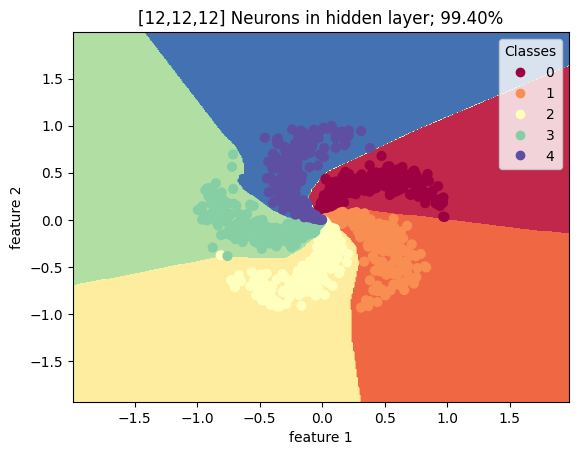

In [13]:
num_epochs=2000; activation_L_1="relu"; activation_L="softmax"
learning_rate = 0.0006; layers_dims=[X.shape[-1],12,12,12, 5]
plt.rcParams["figure.figsize"] = plt.rcParamsDefault["figure.figsize"]
nn_model = L_layer_model(X, Y_true, layers_dims, learning_rate, num_epochs, activation_L_1, activation_L, print_cost=False)
Y_pred = nn_model.model.predict(X, batch_size=X.shape[0], verbose=0)
acc.reset_states()
acc.update_state(Y_true, Y_pred)
# print(f"train accuracy: { acc.result().numpy().item() *100 } %")
# plot_costs(costs, learning_rate)
plot_decision_boundary(nn_model.model.predict, X_np, Y_np)
plt.title(f"[12,12,12] Neurons in hidden layer; {acc.result().numpy().item()*100:.2f}%")